In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATASETS
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE CELL.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote
from urllib.error import HTTPError
from zipfile import ZipFile

CHUNK_SIZE = 40960 
DATASET_MAPPING = 'riiid-test-answer-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F21651%2F1595136%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20201210%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20201210T050831Z%26X-Goog-Expires%3D259199%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7259b9c478a3172780bd385b65368cd8574881dbfebf7aa5eb18336db7ca2c108b24601c5b9e7cc7606313d06fb161c72bfff98dfdea69efe0daaf4e1d2763f78b12c67d6b4ed8d892de1bf486dbe3d36b525c0f058295595492192f780802a9f4e0b84e4e3736458dcdc8dc13af412730256c607b25a977046c22b97d2745315f4acfeabc06186b12bf6f74ffff7da4649741b4a20b913224f3b83ab8fd8d6af5ef8f0a8cd2706b1bb96b8bd448047abe1a8e1a59114588f2efefe69ecd40e218f59a333e027390443ca52ddd37a41f4b50ba9722adc2a14c5f6211c302bcee6fe49013f1dd0c8288acb60be45657880948e6d16acbe1b2f01f374efd66e185,riiid-train-data-multiple-formats:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F917440%2F1556341%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20201210%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20201210T050831Z%26X-Goog-Expires%3D259199%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da7b9224ca75f83ba6fac399da7c6593424e2e2dfe774559b5b0d72aebc8cc3682a4d853a33270399c4e06fd7122e0dfc5e9521beaf8b8f6ed3b25b4553209a3992a51f0906de75c786e9eba776e74578028c52aabeed26ef5acc988767b559ec68e292205e7b2e2dd9fd7ea744554ee0bfd779153dd55cc495610debe5ee65785286aad205ddbbcd7ede32fa2815eb7fbd5578b269b3b4fcec8a3403864633baa7d16c84db39212c15da190748a176be3c3879a6c1910127ac5398553ddb802b94d5bcc2422b9c5ba5774ddf46fea9dc6d39fe3752be6f5b5a02af35d743fd6e30265290bb9ddf66b46d315a5c3dd0c9ef685803629b698a5a60ae0c19e50089'
KAGGLE_INPUT_PATH='/home/kaggle/input'
KAGGLE_INPUT_SYMLINK='/kaggle'

os.makedirs(KAGGLE_INPUT_PATH, 777)
os.symlink(KAGGLE_INPUT_PATH, os.path.join('..', 'input'), target_is_directory=True)
os.makedirs(KAGGLE_INPUT_SYMLINK)
os.symlink(KAGGLE_INPUT_PATH, os.path.join(KAGGLE_INPUT_SYMLINK, 'input'), target_is_directory=True)

# for dataset_mapping in DATASET_MAPPING.split(','):
dataset_mapping = DATASET_MAPPING.split(',')[0]
directory, download_url_encoded = dataset_mapping.split(':')
download_url = unquote(download_url_encoded)
destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
try:
    with urlopen(download_url) as zipfileres, NamedTemporaryFile() as tfile:
        total_length = zipfileres.headers['content-length']
        print(f'Downloading {directory}, {total_length} bytes zipped')
        dl = 0
        data = zipfileres.read(CHUNK_SIZE)
        while len(data) > 0:
            dl += len(data)
            tfile.write(data)
            done = int(50 * dl / int(total_length))
            sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
            sys.stdout.flush()
            data = zipfileres.read(CHUNK_SIZE)
        print(f'\nUnzipping {directory}')
        with ZipFile(tfile) as zfile:
            zfile.extractall(destination_path)
except HTTPError as e:
    print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
#     continue
except OSError as e:
    print(f'Failed to load {download_url} to path {destination_path}')
#     continue
print('Dataset import complete.')

[==================================================] 1386476890 bytes downloaded
Unzipping riiid-test-answer-prediction
Dataset import complete.


In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt
# import riiideducation
import random
from sklearn.metrics import roc_auc_score
import gc

_ = np.seterr(divide='ignore', invalid='ignore')

In [2]:
data_types_dict = {
    'timestamp': 'int64',
    'user_id': 'int32', 
    'content_id': 'int16', 
    'content_type_id':'int8', 
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'

In [5]:
train_df = dt.fread('../input/riiid-test-answer-prediction/train.csv', columns=set(data_types_dict.keys())).to_pandas().astype(data_types_dict)

number of lectures user watches cumulative sum and cumulative mean

In [6]:
cum = train_df.groupby('user_id')['content_type_id'].agg(['cumsum', 'cumcount'])
train_df['user_lecture_cumsum'] = cum['cumsum'].astype('int8')
train_df['user_lecture_mean'] = (cum['cumsum'] / cum['cumcount']).astype('float16').fillna(0)

user_lecture_agg = train_df.groupby('user_id')['content_type_id'].agg(['sum', 'count'])

In [7]:
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df = train_df[train_df[target] != -1].reset_index(drop=True)
prior_question_elapsed_time_mean = train_df['prior_question_elapsed_time'].mean()
train_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)

In [8]:
max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max']).reset_index()
max_timestamp_u.columns = ['user_id', 'max_time_stamp']

In [9]:
train_df['lagtime'] = train_df.groupby('user_id')['timestamp'].shift()
train_df['lagtime'] = train_df['timestamp']-train_df['lagtime']
train_df['lagtime'] = train_df['lagtime'].fillna(0).astype('int32')

train_df.drop(columns=['timestamp'], inplace=True)

In [10]:
lagtime_agg = train_df.groupby('user_id')['lagtime'].agg(['mean'])
train_df['lagtime_mean'] = train_df['user_id'].map(lagtime_agg['mean']).astype('int32')

In [11]:
user_prior_question_elapsed_time = train_df[['user_id','prior_question_elapsed_time']].groupby(['user_id']).tail(1)
user_prior_question_elapsed_time.columns = ['user_id', 'prior_question_elapsed_time']

In [12]:
train_df['delta_prior_question_elapsed_time'] = train_df.groupby('user_id')['prior_question_elapsed_time'].shift()
train_df['delta_prior_question_elapsed_time']=train_df['prior_question_elapsed_time']-train_df['delta_prior_question_elapsed_time']
train_df['delta_prior_question_elapsed_time'].fillna(0, inplace=True)

In [13]:
train_df.delta_prior_question_elapsed_time=train_df.delta_prior_question_elapsed_time.astype('int32')

In [14]:
train_df.prior_question_had_explanation=train_df.prior_question_had_explanation.astype('int8')

train_df['lag'] = train_df.groupby('user_id')['prior_question_had_explanation'].shift()

In [15]:
cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['explanation_mean'] = cum['cumsum'] / cum['cumcount']
train_df['explanation_cumsum'] = cum['cumsum'] 
train_df.drop(columns=['lag'], inplace=True)

train_df['explanation_mean'].fillna(0, inplace=True)
train_df['explanation_cumsum'].fillna(0, inplace=True)
train_df.explanation_mean=train_df.explanation_mean.astype('float16')
train_df.explanation_cumsum=train_df.explanation_cumsum.astype('int16')

In [16]:
train_df['lag'] = train_df.groupby('user_id')[target].shift()

cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df['user_correct_cumsum'] = cum['cumsum']
train_df['user_correct_cumcount'] = cum['cumcount']
# train_df.drop(columns=['lag'], inplace=True)

# train_df['user_correctness'].fillna(1, inplace=True)
train_df['user_correct_cumsum'].fillna(0, inplace=True)
#train_df['user_correct_cumcount'].fillna(0, inplace=True)
train_df.user_correctness=train_df.user_correctness.astype('float16')
train_df.user_correct_cumcount=train_df.user_correct_cumcount.astype('int16')
train_df.user_correct_cumsum=train_df.user_correct_cumsum.astype('int16')

In [17]:
del cum
gc.collect()

237

In [18]:
train_df["attempt_no"] = 1
train_df.attempt_no = train_df.attempt_no.astype('int8')
train_df["attempt_no"] = train_df[["user_id","content_id",'attempt_no']].groupby(["user_id","content_id"])["attempt_no"].cumsum()

In [19]:
train_df.head()

,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_lecture_cumsum,user_lecture_mean,lagtime,lagtime_mean,delta_prior_question_elapsed_time,explanation_mean,explanation_cumsum,lag,user_correctness,user_correct_cumsum,user_correct_cumcount,attempt_no
0,115,5692,0,1,3,1,13005.081055,1,0,0.0,0,14523696,0,0.000000,0,NaN,NaN,0,0,1
1,115,5716,0,2,2,1,37000.000000,0,0,0.0,56943,14523696,23994,1.000000,1,1.0,1.0,1,1,1
2,115,128,0,0,0,1,55000.000000,0,0,0.0,61420,14523696,18000,0.500000,1,1.0,1.0,2,2,1
3,115,7860,0,3,0,1,19000.000000,0,0,0.0,12804,14523696,-36000,0.333252,1,1.0,1.0,3,3,1
4,115,7922,0,4,1,1,11000.000000,0,0,0.0,6798,14523696,-8000,0.250000,1,1.0,1.0,4,4,1


In [20]:
# user_agg = train_df.groupby('user_id')[target].agg(['sum', 'count'])
# content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count','var'])
# task_container_agg = train_df.groupby('task_container_id')[target].agg(['sum', 'count','var'])
user_agg = train_df.groupby('user_id')['lag'].agg(['sum', 'count'])
content_agg = train_df.groupby('content_id')['lag'].agg(['sum', 'count','var'])
task_container_agg = train_df.groupby('task_container_id')['lag'].agg(['sum', 'count','var'])
train_df.drop(columns=['lag'], inplace=True)

#prior_question_elapsed_time_agg = train_df.groupby('user_id')['prior_question_elapsed_time'].agg(['sum', 'count'])

In [21]:
user_agg=user_agg.astype('int16')
content_agg=content_agg.astype('float32')
task_container_agg=task_container_agg.astype('float32')

In [22]:
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')
train_df['content_sum'] = train_df['content_id'].map(content_agg['sum']).astype('int32')
train_df['content_correctness'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count']).astype('float16')

train_df['task_container_sum'] = train_df['task_container_id'].map(task_container_agg['sum']).astype('int32')
train_df['task_container_std'] = train_df['task_container_id'].map(task_container_agg['var']).astype('float16')
train_df['task_container_correctness'] = train_df['task_container_id'].map(task_container_agg['sum'] / task_container_agg['count'])
train_df.task_container_correctness=train_df.task_container_correctness.astype('float16')

In [23]:
questions_df = pd.read_csv(
    '../input/riiid-test-answer-prediction/questions.csv', 
    usecols=[0,1,3,4],
    dtype={'question_id': 'int16', 'bundle_id': 'int16', 'part': 'int8','tags': 'str'}
)
# questions_df['part_bundle_id'] = questions_df['part']*100000+questions_df['bundle_id']
# questions_df.part_bundle_id = questions_df.part_bundle_id.astype('int32')
tag = questions_df["tags"].str.split(" ", n=10, expand=True)
tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']
#

tag.fillna(0, inplace=True)
tag = tag.astype('int16')
questions_df =  pd.concat([questions_df,tag],axis=1).drop(['tags'],axis=1)

In [24]:
questions_df.rename(columns={'question_id':'content_id'}, inplace=True)

In [25]:
questions_df['content_correctness'] = questions_df['content_id'].map(content_agg['sum'] / content_agg['count'])
questions_df.content_correctness = questions_df.content_correctness.astype('float16')
questions_df['content_correctness_std'] = questions_df['content_id'].map(content_agg['var'])
questions_df.content_correctness_std = questions_df.content_correctness_std.astype('float16')

In [26]:
part_agg = questions_df.groupby('part')['content_correctness'].agg(['mean', 'var'])
questions_df['part_correctness_mean'] = questions_df['part'].map(part_agg['mean']).astype('float16')
questions_df['part_correctness_std'] = questions_df['part'].map(part_agg['var']).astype('float16')

In [27]:
bundle_agg = questions_df.groupby('bundle_id')['content_correctness'].agg(['mean'])
questions_df['bundle_correctness'] = questions_df['bundle_id'].map(bundle_agg['mean']).astype('float16')

In [28]:
for i in range(1,7):
    tags_agg = questions_df.groupby(f'tags{i}')['content_correctness'].agg(['mean', 'var'])
    questions_df[f'tags{i}_correctness_mean'] = questions_df[f'tags{i}'].map(tags_agg['mean']).astype('float16')
    questions_df[f'tags{i}_correctness_std'] = questions_df[f'tags{i}'].map(tags_agg['var']).astype('float16')

In [29]:
del bundle_agg
del part_agg
del tags_agg
del tag
gc.collect()

146

In [30]:
train_df['user_correctness'].fillna(1, inplace=True)
train_df['attempt_no'].fillna(1, inplace=True)

train_df.fillna(0, inplace=True)

In [31]:
train_df.head()

,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_lecture_cumsum,user_lecture_mean,...,user_correctness,user_correct_cumsum,user_correct_cumcount,attempt_no,content_count,content_sum,content_correctness,task_container_sum,task_container_std,task_container_correctness
0,115,5692,0,1,3,1,13005.081055,1,0,0.0,...,1.0,0,0,1,33294,19482,0.584961,267081,0.218018,0.678711
1,115,5716,0,2,2,1,37000.000000,0,0,0.0,...,1.0,1,1,1,23919,15838,0.662109,208583,0.249268,0.527832
2,115,128,0,0,0,1,55000.000000,0,0,0.0,...,1.0,2,2,1,5406,3899,0.721191,2868,0.246460,0.560059
3,115,7860,0,3,0,1,19000.000000,0,0,0.0,...,1.0,3,3,1,21732,20035,0.921875,172486,0.245972,0.436523
4,115,7922,0,4,1,1,11000.000000,0,0,0.0,...,1.0,4,4,1,19408,17972,0.925781,352285,0.249878,0.509277


In [35]:
train_df.loc[:, train_df.dtypes == 'float16'] = train_df.loc[:, train_df.dtypes == 'float16'].astype('float32')
train_df.to_parquet('train_features_full.parquet')

In [38]:
questions_df.loc[:, questions_df.dtypes == 'float16'] = questions_df.loc[:, questions_df.dtypes == 'float16'].astype('float32')
questions_df.to_parquet('question_features_full.parquet')

# training

In [3]:
train_df = pd.read_parquet('./train_features_full.parquet')
questions_df = pd.read_parquet('./question_features_full.parquet')

In [4]:
# convert dtypes back for memory efficiency
train_df_prior_question_elapsed_time = train_df.prior_question_elapsed_time
train_df.loc[:, train_df.dtypes == 'float32'] = train_df.loc[:, train_df.dtypes == 'float32'].astype('float16')
train_df.prior_question_elapsed_time = train_df_prior_question_elapsed_time
questions_df.loc[:, questions_df.dtypes == 'float32'] = questions_df.loc[:, questions_df.dtypes == 'float32'].astype('float16')
del train_df_prior_question_elapsed_time

In [5]:
train_df = pd.merge(train_df, questions_df, on='content_id', how='left',right_index=True, suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [6]:
train_df = train_df.groupby('user_id').tail(1000)
valid_df = train_df.groupby('user_id').tail(8)
train_df.drop(valid_df.index, inplace=True)

In [7]:
params = {
'num_leaves': 350,
'max_bin':700,
'min_child_weight': 0.03454472573214212,
'feature_fraction': 0.58,
'bagging_fraction': 0.58,
#'min_data_in_leaf': 106,
'objective': 'binary',
'max_depth': -1,
'learning_rate': 0.05,
"boosting_type": "gbdt",
"bagging_seed": 11,
"metric": 'auc',
"verbosity": -1,
'reg_alpha': 0.3899927210061127,
'reg_lambda': 0.6485237330340494,
'random_state': 47
}

In [8]:
features = [
#     'user_id',
#     'timestamp',
    'lagtime',
    'lagtime_mean',
    'content_id',
    'task_container_id',
    'user_lecture_cumsum',
    'user_lecture_mean',
    'prior_question_elapsed_time',
    'delta_prior_question_elapsed_time',
    'user_correctness',
    'user_correct_cumcount',
    'user_correct_cumsum',
    'content_correctness',
    'content_correctness_std',
    'content_count',
    'content_sum',
    'task_container_correctness',
    'task_container_std',
    'task_container_sum',
    'bundle_correctness',
    'attempt_no',
    
    'part',
    'part_correctness_mean',
    'part_correctness_std',
    'tags1',
    'tags1_correctness_mean',
    'tags1_correctness_std',
    'tags2',
    'tags2_correctness_mean',
    'tags2_correctness_std',
    'tags3',
    'tags3_correctness_mean',
    'tags3_correctness_std',
    'tags4',
    'tags5',
    'tags6',
    'bundle_id',
    'explanation_mean', 
    'explanation_cumsum',
    'prior_question_had_explanation',
]
categorical_columns= [
    'content_id',
    'task_container_id',
    'bundle_id',
    
    'part',        
    'tags1',
    'tags2',
    'tags3',
    'tags4',
    'tags5',
    'tags6',
    'prior_question_had_explanation',
]


In [9]:
train_df.dtypes

user_id                                int32
content_id                             int16
content_type_id                         int8
task_container_id                      int16
user_answer                             int8
answered_correctly                      int8
prior_question_elapsed_time          float32
prior_question_had_explanation          int8
user_lecture_cumsum                     int8
user_lecture_mean                    float16
lagtime                                int32
lagtime_mean                           int32
delta_prior_question_elapsed_time      int32
explanation_mean                     float16
explanation_cumsum                     int16
user_correctness                     float16
user_correct_cumsum                    int16
user_correct_cumcount                  int16
attempt_no                              int8
content_count                          int32
content_sum                            int32
content_correctness                  float16
task_conta

In [10]:
tr_data = lgb.Dataset(train_df[features], label=train_df[target])
va_data = lgb.Dataset(valid_df[features], label=valid_df[target])

In [11]:
del train_df
del valid_df
gc.collect()

22

In [12]:
model = lgb.train(
        params, 
        tr_data,
        num_boost_round=5000,
        valid_sets=[tr_data, va_data],
        early_stopping_rounds=50,
        feature_name=features,
        categorical_feature=categorical_columns,
        verbose_eval=50
    )

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bundle_id', 'content_id', 'part', 'prior_question_had_explanation', 'tags1', 'tags2', 'tags3', 'tags4', 'tags5', 'tags6', 'task_container_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.765834	valid_1's auc: 0.748541
[100]	training's auc: 0.77126	valid_1's auc: 0.75338
[150]	training's auc: 0.774454	valid_1's auc: 0.755304
[200]	training's auc: 0.776977	valid_1's auc: 0.756418
[250]	training's auc: 0.778977	valid_1's auc: 0.757089
[300]	training's auc: 0.780522	valid_1's auc: 0.757507
[350]	training's auc: 0.781883	valid_1's auc: 0.757902
[400]	training's auc: 0.783008	valid_1's auc: 0.758094
[450]	training's auc: 0.784067	valid_1's auc: 0.758246
[500]	training's auc: 0.785029	valid_1's auc: 0.758338
[550]	training's auc: 0.785902	valid_1's auc: 0.758497
[600]	training's auc: 0.786705	valid_1's auc: 0.758537
[650]	training's auc: 0.787477	valid_1's auc: 0.758596
[700]	training's auc: 0.788283	valid_1's auc: 0.758654
[750]	training's auc: 0.788965	valid_1's auc: 0.758733
[800]	training's auc: 0.78957	valid_1's auc: 0.758784
[850]	training's auc: 0.790233	valid_1's auc: 0.758803
[900]	tr

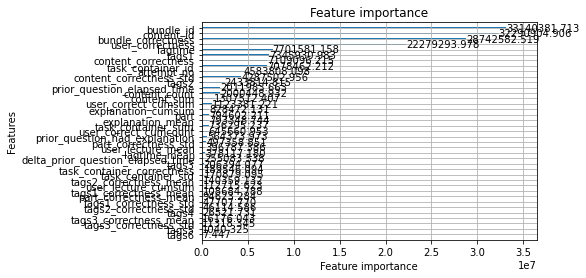

In [13]:
lgb.plot_importance(model, importance_type='gain')

In [14]:
model.save_model(f'model.txt')